In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import cv2
import scipy

# third party packages
from PIL import Image

# from my code
from repo_tools import shorten_image_file_names
from image_tools import convolve_image_horizontal_filter, find_all_non_white_pixels, identify_rgb_of_data, find_all_data_point_pixel_locations
from signals_processing_tools import remove_double_peaks, remove_baseline_wander, find_peaks, compute_y_calibrations
from data_tools import calculate_pixel_location, generate_dict_y_coords_for_kW

### find images

In [2]:
# old_img_names = os.listdir(os.path.join("data", "images"))
cwd = os.getcwd()
# old_img_paths = {img_name: os.path.join(cwd, "data", "images", img_name) for img_name in old_img_names}
# shorten_image_file_names(old_img_paths, cwd)

img_names = [img_name for img_name in os.listdir(os.path.join("data", "images")) if "png" in img_name]
img_paths = {img_name: os.path.join(cwd, "data", "images", img_name) for img_name in img_names}
img_paths.keys()

dict_keys(['123946.png', '124245.png', '124105.png', '124205.png'])

### import image

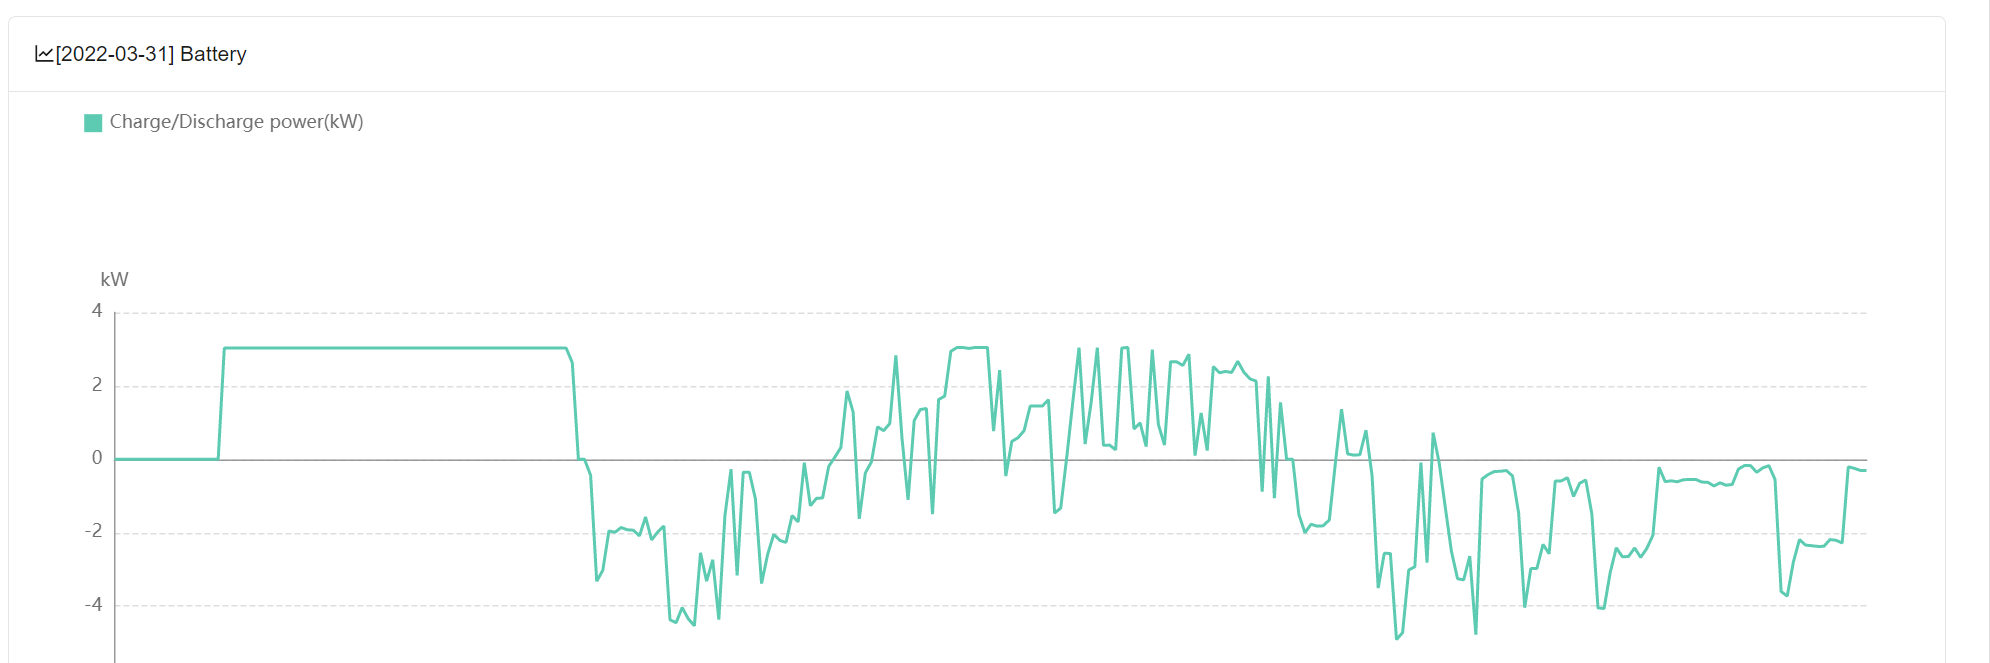

In [3]:
# exract the image
img = Image.open(img_paths[img_names[0]]).convert("RGB")

# show the image
img

### plot colours and find rgb values of plot

In [4]:
col_names = ['r', 'g', 'b']
df_coloured_pixels = find_all_non_white_pixels(img, col_names)

In [5]:
target_col_dict = identify_rgb_of_data(df_coloured_pixels, col_names, show_plots=False)
# target_col_dict, plots = identify_rgb_of_data(df_coloured_pixels, col_names, show_plots=True)
# plots

Now that we know the pixel colour values corresponding to the data in the plot, a function to find all these datapoints from the image is needed using the target_col_dict.

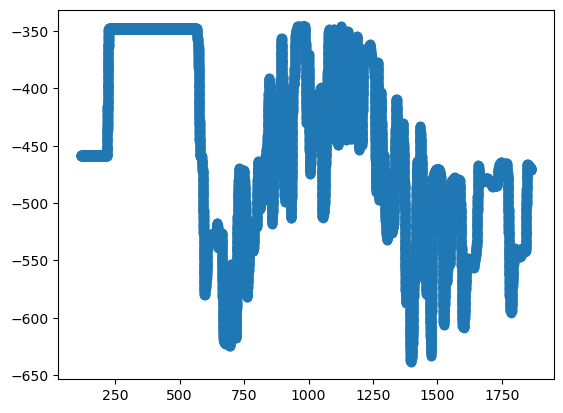

In [6]:
arr_data_pix_coords = find_all_data_point_pixel_locations(img, target_col_dict)

plt.scatter(arr_data_pix_coords[:,0], -1*arr_data_pix_coords[:,1])

Clearly this method has found the correct data points.

## y calibration

In [7]:
y_coord_dict, baseline_y, kw_per_pixel = compute_y_calibrations(img)

#### checking y calibration

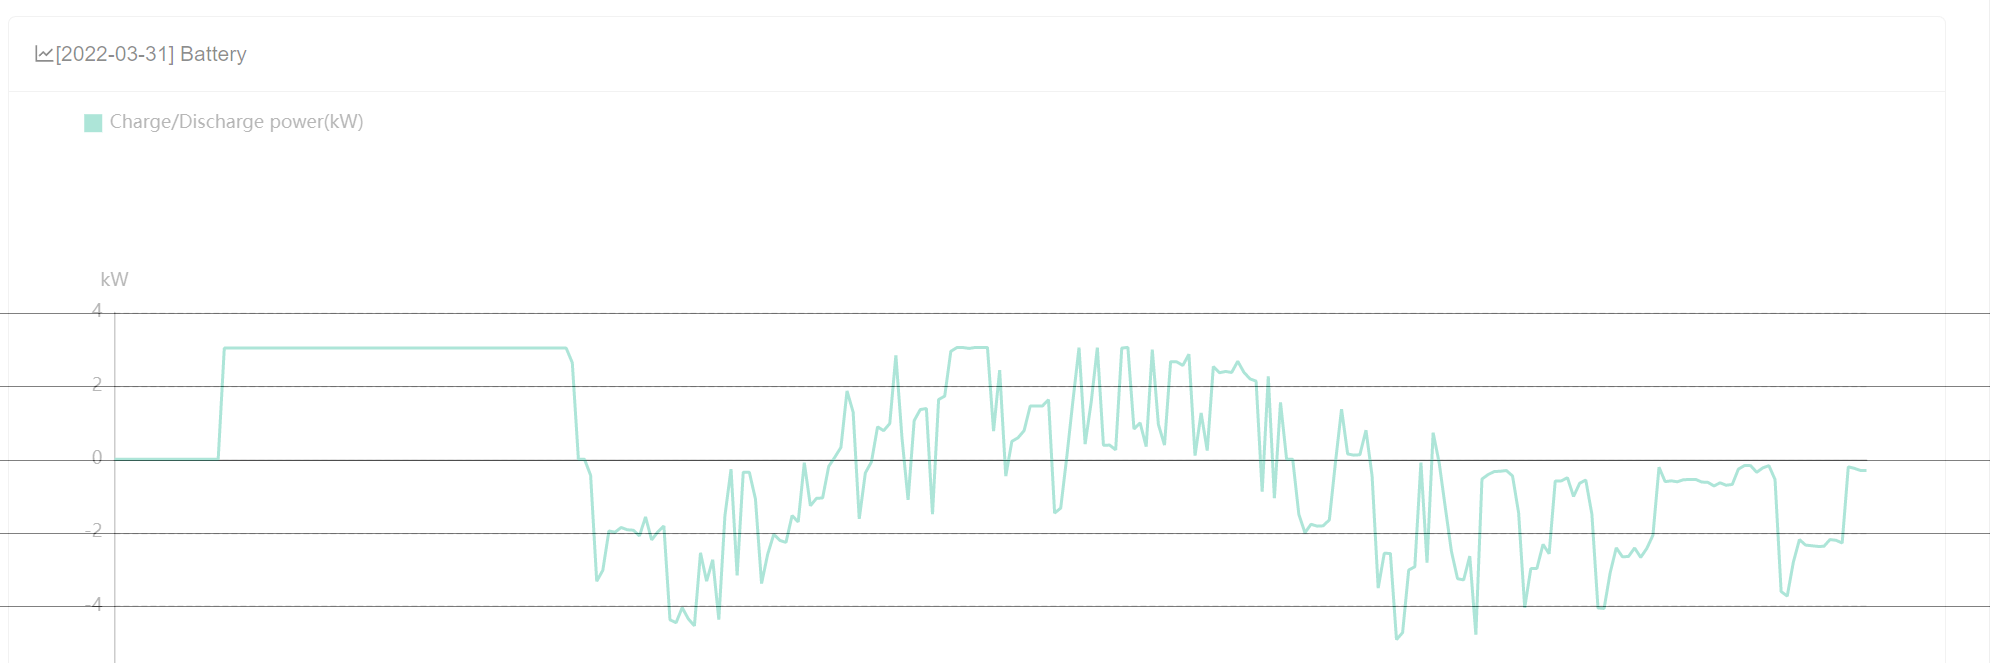

In [17]:
# check these values 
img_arr = np.asarray(img)
img_height = img_arr.shape[0]
img_width = img_arr.shape[1]
min(arr_data_pix_coords[:,1])

# generate white page with black lines image for pasting on top of original image, for reference
black_line_pix_values = np.zeros((1,img_width,3), dtype="uint8")
white_image = np.ones(np.shape(img_arr),dtype="uint8")*255
for y_val in y_coord_dict:
    white_image[y_coord_dict[y_val]] =  black_line_pix_values
    
lines = Image.fromarray(white_image)
img_with_lines = img.copy()
lines.putalpha(127) # make partially transparent

# paste the two images together
img_with_lines.paste(lines, (0,0), lines)
img_with_lines

This plot shows the original image with an overlay of the predicted y grid lines using the image processing tools defined in this repository. They should line up. 

## x calibration 

In [18]:
baseline_x = min(arr_data_pix_coords[:,0])
last_data_point_x = max(arr_data_pix_coords[:,0])
seconds_in_day = 60*60*24
seconds_per_pixel = seconds_in_day / abs(last_data_point_x - baseline_x)
baseline_x, seconds_per_pixel

(115, 49.371428571428574)

# putting them together

Text(0, 0.5, 'kW')

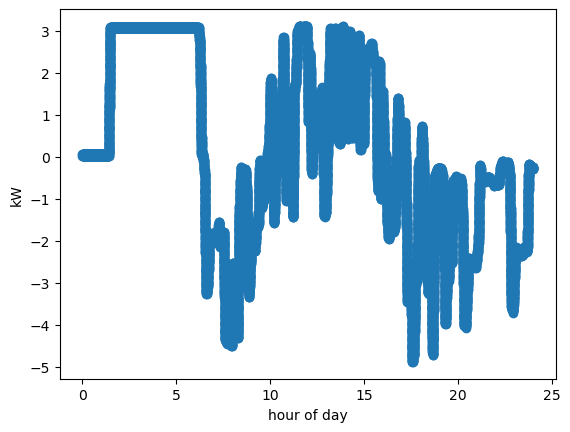

In [12]:
# extract array of data values with dimensions in Y of kW, and x of seconds in the day
data_x = (arr_data_pix_coords[:,0] - baseline_x) * seconds_per_pixel
data_y = (arr_data_pix_coords[:,1] - baseline_y) * kw_per_pixel

plt.scatter(data_x*24/seconds_in_day, data_y)
plt.xlabel("hour of day")
plt.ylabel("kW")

This looks good.